In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mundey
import tessbkgd
import halophot

In [8]:
tpffile = 'tess2018349182459-s0006-0000000322899250-0126-s_tp.fits'

In [9]:
tpf = mundey.mundey.mundey_tpf(tpffile)

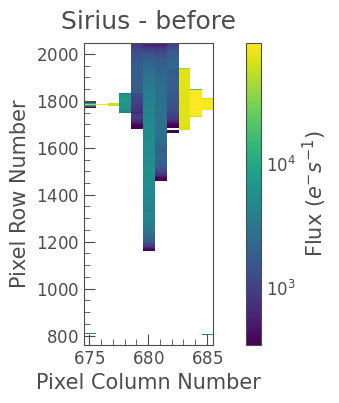

In [10]:
tpf.plot(aspect=0.02,scale = 'log',interpolation='nearest',title='Sirius - before');

## Use `mundey` to recalibrate TPF

In [11]:
str(tpf.targetid)

'322899250'

In [12]:
tpf.calibrate(use_simbad=False)

Beginning calibration of TIC 322899250
Sector: 6
Camera: 2
CCD: 3
Outputs: {'B'}

Searching for collateral target pixel files
... loading smear file ./tess2018349182459-s0006-smrow-2-3-b-0126-s_col-blf.fits
... file not found: ./tess2018349182459-s0006-smrow-2-3-b-0126-s_col-blf.fits
... smear correction will be calculated from raw counts
... loading smear row file ./tess2018349182459-s0006-smrow-2-3-b-0126-s_col.fits

... loading 1D black file ./tess2018349182459-s0006-tvcol-2-3-b-0126-s_col-blf.fits
... file not found: ./tess2018349182459-s0006-tvcol-2-3-b-0126-s_col-blf.fits
... 1D black correction will be calculated from raw counts
... loading trailing virtual column file ./tess2018349182459-s0006-tvcol-2-3-b-0126-s_col.fits


Adjusting for fixed offset and mean black - Output B

Loading 2D black model
... ./tess2018323-2-3-2dblack.fits
Performing 2-D black correction

Calculating 1-D black correction
... this step may take a while;
... if you haven't already done so
... you might 

Frame:   0%|          | 0/100 [00:00<?, ?it/s]/home/tim/.local/lib/python3.6/site-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
Frame: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Performing 1-D black correction
Performing 1-D black correction

Correcting for non-linearity and gain

Correcting for LDE undershoot

Calculating photometric smear

Removing photometric smear

Loading flat field
... ./tess2018323-2-3-flat.fits
Performing flatfield correction

Converting to electrons per second

Calibration Complete


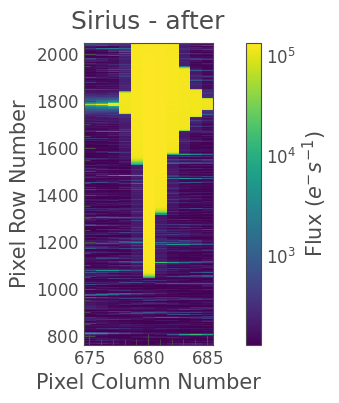

In [13]:
tpf.plot(aspect=0.02,scale = 'log',interpolation='nearest',title='Sirius - after');

In [14]:
np.nansum(tpf.flux.value)

41293316000.0

## Use `tessbkgd` to estimate the background

In [15]:
tpf.__class__ = tessbkgd.tessbkgd.bkgd_tpf

In [16]:
newbkgd,bkgdmask = tpf.get_bkgd(verbose=True)

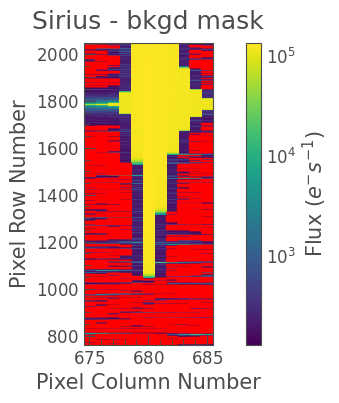

In [17]:
tpf.plot(aspect=0.02,scale = 'log',interpolation='nearest',title='Sirius - bkgd mask',aperture_mask = bkgdmask);

In [18]:
if np.nansum(tpf.flux_bkg) == 0:  #No background previously set
    tpf.flux = tpf.flux - newbkgd
    tpf.flux_bkg = newbkgd
else:    #Need to add old background back in
    tpf.flux = tpf.flux + tpf.flux_bkg - newbkgd
    tpf.flux_bkg = newbkgd

## Use `halophot` to calculate light curve

In [19]:
tpf.__class__ = halophot.halo_tools.halo_tpf_tess

In [20]:
halomask = np.ones((tpf.flux.shape[1],tpf.flux.shape[2]),dtype='bool')

yy,xx = np.meshgrid(np.arange(halomask.shape[0]),np.arange(halomask.shape[1]))

row1 = 1700
row2 = 1875
y1 = tpf.hdu[2].header['CRVAL2P']-1

halomask[(yy<row1-y1).T] = False
halomask[(yy>row2-y1).T] = False

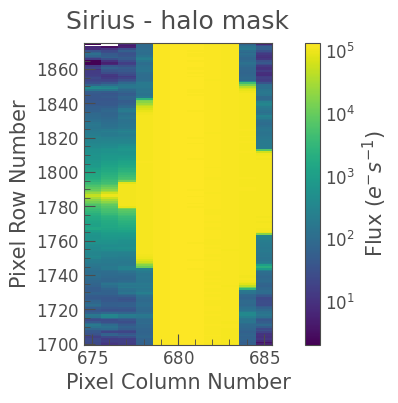

In [21]:
ax = tpf.plot(aspect=0.1,scale = 'log',interpolation='nearest',title='Sirius - halo mask')
ax.set_ylim(row1-0.5,row2+0.5)
plt.show()

In [22]:
%%time
weightmap, corr_lc = tpf.halo(objective='tv',mask=halomask,minflux=0,thresh=0.7)

Taking cadences from beginning to end
1140 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
CPU times: user 1.46 s, sys: 832 ms, total: 2.3 s
Wall time: 894 ms


/usr/local/lib/python3.6/dist-packages/halophot-0.7.4-py3.6.egg/halophot/halo_tools.py:1247: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/api/lightkurve.lightcurve.LightCurve.html
/usr/local/lib/python3.6/dist-packages/halophot-0.7.4-py3.6.egg/halophot/halo_tools.py:1248: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/api/lightkurve.lightcurve.LightCurve.html
/usr/local/lib/python3.6/dist-packages/halophot-0.7.4-py3.6.egg/halophot/halo_tools.py:1249: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.l

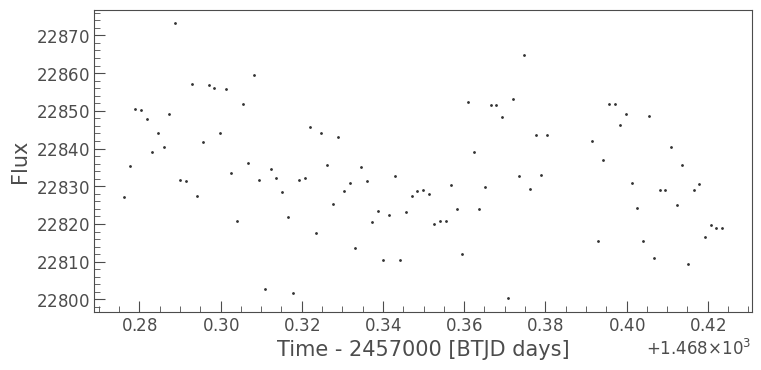

In [23]:
corr_lc.scatter();

In [18]:
corr_lc.to_fits('test.fits',overwrite=True)
test = lk.read('test.fits')

In [19]:
import hdfdict,h5py
# weightmap
file = h5py.File('tess2018349182459-s0006-0000000322899250-0126-s_halo_meta.hd5','a')
file.clear()
# file.close()
hdfdict.dump(weightmap,file)
file.close()

In [20]:
import hdfdict,h5py
# weightmap
file = h5py.File('tess2018349182459-s0006-0000000322899250-0126-s_halo_meta.hd5','a')
# file.clear()
# file.close()
weightmap = dict(hdfdict.load(file))
file.close()

In [21]:
weightmap

{'final_cadence': 173494,
 'initial_cadence': 173388,
 'sat_pixels': 11,
 'weightmap': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

In [29]:
weightmap['weightmap']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
file

<Closed HDF5 file>

In [23]:
help(hdfdict.dump)

Help on function dump in module hdfdict.hdfdict:

dump(data, hdf, packer=<function pack_dataset at 0x7fb668e0ba60>, *args, **kwargs)
    Adds keys of given dict as groups and values as datasets
    to the given hdf-file (by string or object) or group object.
    
    Parameters
    ----------
    data : dict
        The dictionary containing only string keys and
        data values or dicts again.
    hdf : string (path to file) or `h5py.File()` or `h5py.Group()`
    packer : callable
        Callable gets `hdfobject, key, value` as input.
        `hdfobject` is considered to be either a h5py.File or a h5py.Group.
        `key` is the name of the dataset.
        `value` is the dataset to be packed and accepted by h5py.
    
    Returns
    -------
    hdf : obj
        `h5py.Group()` or `h5py.File()` instance



In [24]:
ls tess2018349182459-s0006-0000000322899250-0126-s_halo_meta.hd5

tess2018349182459-s0006-0000000322899250-0126-s_halo_meta.hd5


In [25]:
# corr_lc.mission = 'TESS'
# corr_lc.ra = tpf.ra
# corr_lc.dec = tpf.dec
# corr_lc.camera = tpf.camera
corr_lc.to_fits('test.fits',overwrite=True)

In [26]:
help(lk.TessLightCurve)

Help on class TessLightCurve in module lightkurve.lightcurve:

class TessLightCurve(LightCurve)
 |  TessLightCurve(data=None, *args, time=None, flux=None, flux_err=None, **kwargs)
 |  
 |  Subclass of :class:`LightCurve <lightkurve.lightcurve.LightCurve>`
 |  to represent data from NASA's TESS mission.
 |  
 |  Method resolution order:
 |      TessLightCurve
 |      LightCurve
 |      QTimeSeries
 |      astropy.timeseries.sampled.TimeSeries
 |      astropy.timeseries.core.BaseTimeSeries
 |      astropy.table.table.QTable
 |      astropy.table.table.Table
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  to_fits(self, path=None, overwrite=False, flux_column_name='FLUX', aperture_mask=None, **extra_data)
 |      Writes the KeplerLightCurve to a FITS file.
 |      
 |      Parameters
 |      ----------
 |      path : string, default None
 |          File path, if `None` returns an astropy.io.fits.HDUList object.
 |      overwrite : bool
 |          Whether or not to overwri

In [27]:
tpf.get_header(2)#['CRPIX2']

XTENSION= 'IMAGE   '           / marks the beginning of a new HDU               
BITPIX  =                   32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   11 / length of first array dimension                
NAXIS2  =                 1287 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'APERTURE'           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
TELESCOP= 'TESS    '           / telescope                                      
INSTRUME= 'TESS Photometer' 

In [28]:
tpf.row+tpf.get_header(2)['CRPIX2']

1787.4082480668849

In [33]:
'TIC %s, Sector %d' % (tpf.targetid, tpf.sector)

'TIC 322899250, Sector 6'

In [38]:
for j in range(1,37):   
    print('curl -C  - -L -o tesscurl_sector_{s}_cbv.sh https://archive.stsci.edu/missions/tess/download_scripts/sector/tesscurl_sector_{s}_cbv.sh'.format(s=j))
    
    
    
    

curl -C  - -L -o tesscurl_sector_1_cbv.sh https://archive.stsci.edu/missions/tess/download_scripts/sector/tesscurl_sector_1_cbv.sh
curl -C  - -L -o tesscurl_sector_2_cbv.sh https://archive.stsci.edu/missions/tess/download_scripts/sector/tesscurl_sector_2_cbv.sh
curl -C  - -L -o tesscurl_sector_3_cbv.sh https://archive.stsci.edu/missions/tess/download_scripts/sector/tesscurl_sector_3_cbv.sh
curl -C  - -L -o tesscurl_sector_4_cbv.sh https://archive.stsci.edu/missions/tess/download_scripts/sector/tesscurl_sector_4_cbv.sh
curl -C  - -L -o tesscurl_sector_5_cbv.sh https://archive.stsci.edu/missions/tess/download_scripts/sector/tesscurl_sector_5_cbv.sh
curl -C  - -L -o tesscurl_sector_6_cbv.sh https://archive.stsci.edu/missions/tess/download_scripts/sector/tesscurl_sector_6_cbv.sh
curl -C  - -L -o tesscurl_sector_7_cbv.sh https://archive.stsci.edu/missions/tess/download_scripts/sector/tesscurl_sector_7_cbv.sh
curl -C  - -L -o tesscurl_sector_8_cbv.sh https://archive.stsci.edu/missions/tess/d